In [1]:
 ! pip install catboost

In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline 
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [5]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submission_data = pd.read_csv("submission.csv")

In [6]:
train_price = train_data["Price"]
train_data.drop("Price",axis=1,inplace=True)
train_data["Price"] = train_price

In [7]:
display(train_data.head())
display(test_data.head())
display(submission_data.head())

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,45654403,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,13328
1,44731507,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,16621
2,45774419,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2,8467
3,45769185,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0,3607
4,45809263,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,11726


,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN


,Price
0,0
1,0
2,0
3,0
4,0


In [8]:
print(train_data.shape)
print(test_data.shape)

(19237, 18)
(8245, 18)


In [9]:
# sub_data = pd.DataFrame(({"Price" :[10000]*8245 }))
# sub_data.to_csv("sample_submission_check.csv",index=False)

In [10]:
def column_details(df):
  cat = []
  num = []
  for i in df.columns:
    if df[i].dtypes==object:
        cat.append(i)
    else:
        num.append(i)
  print('The numerical data are {}'.format(num))
  print('The categorical data are {}'.format(cat))
  return num,cat

num_col,cat_col = column_details(train_data)

The numerical data are ['ID', 'Prod. year', 'Cylinders', 'Airbags', 'Price']
The categorical data are ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


In [11]:
full_data = pd.concat([train_data,test_data],axis=0)

In [12]:
print(train_data.shape)
print(test_data.shape)
print(full_data.shape)

(19237, 18)
(8245, 18)
(27482, 18)


In [13]:
full_data.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,45654403,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,13328.0
1,44731507,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,16621.0
2,45774419,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2,8467.0
3,45769185,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0,3607.0
4,45809263,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,11726.0


In [14]:
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [15]:
full_data['Prod. year']=full_data['Prod. year'].astype(object)

full_data["Mileage"]=full_data['Mileage'].replace({'1234567899 km':"0 km"})
full_data['Mileage']=full_data['Mileage'].str.replace('km','')
full_data['Mileage']=full_data['Mileage'].astype(int)

full_data['Doors']=full_data['Doors'].replace({'04-May':4,'02-Mar':2})
full_data['Doors']=full_data['Doors'].astype(str)

full_data['Levy']=full_data['Levy'].replace({'-':np.nan})
full_data['Levy']=full_data['Levy'].astype(float)

full_data["Cylinders"]=full_data["Cylinders"].replace({127.0:12})
full_data['Cylinders']=full_data['Cylinders'].astype(str)

full_data['Turbo engine']=full_data['Engine volume'].replace(['2.0 Turbo', '2.2 Turbo','3.0 Turbo','1.4 Turbo','1.5 Turbo', '1.6 Turbo','2.3 Turbo','2.8 Turbo','1.8 Turbo', '2.4 Turbo', '3.5 Turbo', '3.2 Turbo','1.3 Turbo','2.5 Turbo','1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.2 Turbo','4.8 Turbo', '4.6 Turbo','1.2 Turbo','1.7 Turbo', '6.3 Turbo', '2.7 Turbo','2.9 Turbo', '4.0 Turbo','3.6 Turbo','3.7 Turbo','5.5 Turbo','2.1 Turbo','0.7 Turbo', '0.6 Turbo','1.0 Turbo', '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo','5.7 Turbo','0.4 Turbo', '5.4 Turbo', '0.3 Turbo','1.1 Turbo','2.6 Turbo','6.0 Turbo'],'Turbo')
full_data['Turbo engine']=full_data['Turbo engine'].replace(['3.5','3','1.3','2.5','2','1.8','2.4','4','1.6','3.3','4.7','1.5','4.4','3.6','2.3','2.2','1.4','5.5','3.2','3.8','4.6','1.2','5', '1.7', '2.9', '0.5','1.9','2.7','4.8','5.3','0.4','2.8','1.1','2.1','0.7','5.4','3.7','1','2.6','5.7','3.4','4.3','4.2','5.9','6.8','4.5','0.6','7.3','0.1','6.3','6.4','5.2','5.8','0.8', '6.7', '6.2', '0', '20', '0.3', '0.2','5.6', '6', '3.9', '0.9','6.1','6.6','10.8'],'No')
full_data['Turbo engine'] = full_data['Turbo engine'].replace("Turbo","Yes")

full_data['Engine volume']=full_data['Engine volume'].str.replace('Turbo','')
full_data['Engine volume']=full_data['Engine volume'].astype(float)

full_data['Drive wheels']=full_data['Drive wheels'].replace({'4x4':'4-WD'})

full_data["Airbags"] = full_data["Airbags"].astype(str)

full_data["Price"] = full_data["Price"].replace({26307500.0:26307.0})

# full_data['Costly car'] = full_data['Price'].apply(lambda x: 1 if x >= 100000 else 0)

In [16]:
full_data['Mileage'] = full_data['Mileage'].apply(lambda x: x if x <= 500000.0 else 0)

full_data["Mileage"] = full_data["Mileage"].replace(0,full_data["Mileage"].mean())

full_data['Levy'] = full_data['Levy'].fillna(full_data['Levy'].mean())

In [17]:
full_data.drop(["ID","Price","Manufacturer","Model"],axis=1,inplace=True)

In [18]:
full_data_copy = full_data.copy()

In [19]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
for col in full_data_copy.columns.values:
    if full_data_copy.loc[:,col].dtype == "object":
        lbl.fit(full_data_copy.loc[:,col].astype(str))
        full_data_copy.loc[:,col] = lbl.transform(full_data_copy.loc[:,col].astype(str))
        # test.loc[:,col] = lbl.transform(test.loc[:,col].astype(str))

In [20]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
for col in full_data_copy.columns.values:
    if full_data_copy.loc[:,col].dtype == "object":
        lbl.fit(full_data_copy.loc[:,col].astype(int64))
        full_data_copy.loc[:,col] = lbl.transform(full_data_copy.loc[:,col].astype(int64))
        # test.loc[:,col] = lbl.transform(test.loc[:,col].astype(str))

In [21]:
full_data_copy.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
0,1399.000000,48,4,1,2,3.5,186005.0,11,0,0,1,0,12,4,0
1,1018.000000,49,4,0,5,3.0,192000.0,11,2,0,1,0,1,15,0
2,910.160914,44,3,0,5,1.3,200000.0,9,3,1,1,1,1,9,0
3,862.000000,49,4,1,2,2.5,168966.0,9,0,0,1,0,14,0,0
4,446.000000,52,3,1,5,1.3,91901.0,9,0,1,1,0,12,11,0


In [22]:
full_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27482 entries, 0 to 8244
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Levy              27482 non-null  float64
 1   Prod. year        27482 non-null  int32  
 2   Category          27482 non-null  int32  
 3   Leather interior  27482 non-null  int32  
 4   Fuel type         27482 non-null  int32  
 5   Engine volume     27482 non-null  float64
 6   Mileage           27482 non-null  float64
 7   Cylinders         27482 non-null  int32  
 8   Gear box type     27482 non-null  int32  
 9   Drive wheels      27482 non-null  int32  
 10  Doors             27482 non-null  int32  
 11  Wheel             27482 non-null  int32  
 12  Color             27482 non-null  int32  
 13  Airbags           27482 non-null  int32  
 14  Turbo engine      27482 non-null  int32  
dtypes: float64(3), int32(12)
memory usage: 2.1 MB


In [23]:
full_data_copy.columns

Index(['Levy', 'Prod. year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Turbo engine'],
      dtype='object')

In [24]:
sc = StandardScaler()
full_data_copy_sc = pd.DataFrame(sc.fit_transform(full_data_copy))
# test_sc = pd.DataFrame(sc.fit_transform(test))

In [25]:
full_data_copy_sc.columns = full_data_copy.columns

In [26]:
full_data_copy_sc.shape

(27482, 15)

In [27]:
full_data_copy_sc.head()

,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
0,1.282596,-0.166025,-0.817229,0.615795,-0.793472,1.346803,0.525957,1.163112,-0.599015,-1.599316,0.160242,-0.287490,0.790596,-0.717521,-0.334262
1,0.282944,0.014198,-0.817229,-1.623918,0.867362,0.779438,0.595723,1.163112,1.633895,-1.599316,0.160242,-0.287490,-1.259927,1.553387,-0.334262
2,0.000000,-0.886914,-1.175834,-1.623918,0.867362,-1.149602,0.688821,-0.426576,2.750351,0.159765,0.160242,3.478382,-1.259927,0.314710,-0.334262
3,-0.126363,0.014198,-0.817229,0.615795,-0.793472,0.212073,0.327668,-0.426576,-0.599015,-1.599316,0.160242,-0.287490,1.163418,-1.543306,-0.334262
4,-1.217846,0.554865,-1.175834,0.615795,0.867362,-1.149602,-0.569162,-0.426576,-0.599015,0.159765,0.160242,-0.287490,0.790596,0.727602,-0.334262


In [28]:
train = full_data_copy_sc.iloc[:19237]
test = full_data_copy_sc.iloc[19237:]

In [183]:
# display(train.tail())
# display(train_data.tail())

# display(test.head())
# display(test_data.head())

# print(test.shape)
# print(test_data.shape)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels
import statsmodels.api

In [196]:
X = train
y = train_price
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
# xgb = XGBRegressor()
# xgb.fit(X_train,y_train)
# y_pred = xgb.predict(X_test)
# print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error is",mean_squared_error(y_test,y_pred))
# print("R squared Score is",r2_score(y_test,y_pred))
# print("Mean Absolute Logarithmic Error is",np.sqrt(mean_squared_log_error(y_test,y_pred)))

In [26]:
# xgb.fit(X,y)
# y_pred_test = xgb.predict(test)
# price_sub = pd.DataFrame({"Price":np.abs(y_pred_test)})
# price_sub.to_csv("submission_1_xbg_carprice.csv",index = False)
# price_sub.head()

In [39]:
x_train.insert(loc=0,column='intercept',value=np.ones(x_train.shape[0]))

In [40]:
x_train.head()

,intercept,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,1.0,-0.344135,1.415532,-1.044192,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,1.0,0.975616,-1.413256,-0.989432,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.0,1.282596,0.134571,-0.631532,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,1.0,-0.703590,-1.413256,0.563420,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,1.0,0.000000,-1.573376,1.625383,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [41]:
mlr_model=statsmodels.api.OLS(np.log(y_train),x_train).fit()

In [42]:
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     263.6
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:42:00   Log-Likelihood:                -27065.
No. Observations:               15389   AIC:                         5.417e+04
Df Residuals:                   15371   BIC:                         5.430e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            9.0192      0.011    795.827      0.000       8.997       9.041
Levy                -0.0272      0.015     -1.841      0.066      -0.056       0.002
Manufacturer        -0.0742      0.012     -6.304      0.000      -0.097      -0.051
Model                0.0507      0.012      4.224      0.000       0.027       0.074
Prod. year           0.2749      0.014     20.105      0.000       0.248       0.302
Category            -0.0539      0.012     -4.327      0.000      -0.078      -0.030
Leather interior    -0.0632      0.014     -4.490      0.000      -0.091      -0.036
Fuel type           -0.0835      0.012     -6.928      0.000      -0.107      -0.060
Engine volume        0.2202      0.019     11.571      0.000       0.183       0.258
Mileage             -0.2259      0.012    -18.356      0.000      -0.250      -0.202
Cylinders           -0.1043      0.016     -6.363      0.000      -0.136      -0.072
Gear box type        0.3008      0.013     24.038      0.000       0.276       0.325
Drive wheels         0.0181      0.013      1.426      0.154      -0.007       0.043
Doors               -0.0049      0.012     -0.403      0.687      -0.029       0.019
Wheel               -0.1541      0.013    -12.027      0.000      -0.179      -0.129
Color               -0.0076      0.012     -0.656      0.512      -0.030       0.015
Airbags              0.5090      0.012     42.194      0.000       0.485       0.533
Turbo engine         0.1865      0.012     15.609      0.000       0.163       0.210
==============================================================================
Omnibus:                     4218.934   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12632.480
Skew:                          -1.423   Prob(JB):                         0.00
Kurtosis:                       6.406   Cond. No.                         3.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
t_intercept=mlr_model.params[0]/mlr_model.bse[0]

In [44]:
t_slope=mlr_model.params[1]/mlr_model.bse[1]

In [45]:
t_intercept,t_slope

(795.8270263121187, -1.8413957548531126)

In [ ]:
# full_data_engine_volume = pd.DataFrame(full_data["Engine volume"].str.split(' ').to_list(),columns=["Engine volume","Turbo"])
# full_data_engine_volume["Turbo"] = full_data_engine_volume["Turbo"].fillna("No")
# full_data_engine_volume["Turbo"] = full_data_engine_volume["Turbo"].replace({"Turbo":"Yes"}).astype(str)

In [47]:
n=len(train_data)

In [48]:
from scipy import stats

In [49]:
pval_intercept=stats.t.sf(t_intercept,df=n-1)

In [50]:
pval_slope=stats.t.sf(t_slope,df=n-1)

In [51]:
pval_intercept,pval_slope

(0.0, 0.9672105140904255)

In [59]:
mlr_model.params

intercept           9.019236
Levy               -0.027184
Manufacturer       -0.074161
Model               0.050672
Prod. year          0.274892
Category           -0.053945
Leather interior   -0.063235
Fuel type          -0.083531
Engine volume       0.220204
Mileage            -0.225898
Cylinders          -0.104314
Gear box type       0.300814
Drive wheels        0.018077
Doors              -0.004884
Wheel              -0.154072
Color              -0.007583
Airbags             0.508979
Turbo engine        0.186481
dtype: float64

In [52]:
# confidence interval for intercept

a=train_data.shape[0]
loc=mlr_model.params[0]
scale=mlr_model.bse[0]
interval_for_intercept=stats.t.interval(0.95,a-1,loc,scale)

In [53]:
# confidence interval for slope

b=train_data.shape[1]
loc=mlr_model.params[1]
scale=mlr_model.bse[1]
interval_for_slope=stats.t.interval(0.95,b-1,loc,scale)

In [54]:
interval_for_slope,interval_for_intercept

((-0.05832964244530106, 0.003962539834338304),
 (8.997022363247531, 9.041450336138897))

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [62]:
vif=pd.DataFrame()
vif['vif_factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['features']=X.columns

In [63]:
for i in range(len(train.columns)):
    vif=pd.DataFrame()
    vif['vif_factor']=[variance_inflation_factor(train.values,i) for i in range(train.shape[1])]
    vif['features']=train.columns
    multi=vif[vif['vif_factor']>10]
    
    if multi.empty==False:
        df_sort=multi.sort_values(by='vif_factor',ascending=False)
    else:
        print(vif)
        break
        
    if df_sort.empty==False:
        train=train.drop(columns=df_sort['features'].iloc[0])
    else:
        print(vif)

    vif_factor          features
0     1.543905              Levy
1     1.080678      Manufacturer
2     1.121120             Model
3     1.454308        Prod. year
4     1.205520          Category
5     1.534724  Leather interior
6     1.133613         Fuel type
7     2.854242     Engine volume
8     1.174741           Mileage
9     2.078547         Cylinders
10    1.222941     Gear box type
11    1.246387      Drive wheels
12    1.144381             Doors
13    1.280697             Wheel
14    1.037390             Color
15    1.135508           Airbags
16    1.108987      Turbo engine


In [64]:
from statsmodels.graphics.gofplots import qqplot

Skewness of the residuals:  -1.4228854103770725


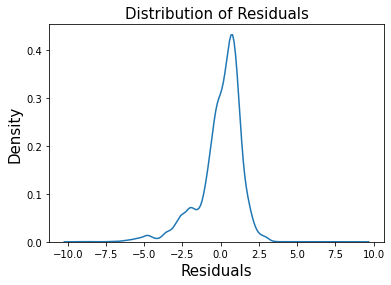

In [65]:
sns.distplot(mlr_model.resid,hist=False)

plt.title('Distribution of Residuals', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

print("Skewness of the residuals: ", mlr_model.resid.skew())

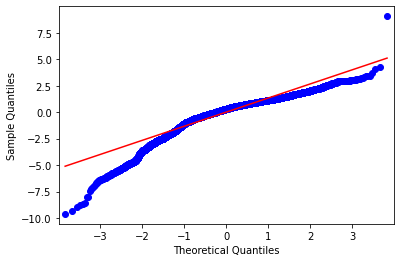

In [66]:
qqplot(mlr_model.resid,line='r')
plt.show()

In [78]:
# x_train.drop("intercept",axis=1,inplace=True)
new_train = x_train.copy()
new_test = x_test.copy()

In [77]:
display(x_train.head())

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,1.415532,-1.044192,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-1.413256,-0.989432,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,0.134571,-0.631532,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,-1.413256,0.563420,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.573376,1.625383,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
linreg=LinearRegression()

In [84]:
linreg.fit(new_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [85]:
# y_pred_train=linreg.predict(new_train)

In [86]:
y_pred_test=linreg.predict(new_test)

In [83]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [87]:
rmse_train=np.sqrt(mean_squared_error(y_test,y_pred_test))

In [88]:
mae_train=mean_absolute_error(y_test,y_pred_test)

In [92]:
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred_test))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R squared Score is",r2_score(y_test,y_pred_test))

Mean Absolute Error is 12946.433584543796
Mean Squared Error is 18256.024798454255
R squared Score is -0.06959583557005966


## **Forward Selection**

In [93]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [94]:
linreg_forward=SequentialFeatureSelector(estimator=linreg,k_features=(5,10),
                                        forward=True,cv=10,
                                        scoring='r2')

In [95]:
sfs_forward=linreg_forward.fit(new_train,y_train)

In [96]:
print('Feature Selection using forward selection are : ',sfs_forward.k_feature_names_)
print('R-Squared : ', sfs_forward.k_score_)

Feature Selection using forward selection are :  ('Model', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Wheel', 'Turbo engine')
R-Squared :  0.10778042716360554


In [108]:
x_train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,1.415532,-1.044192,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-1.413256,-0.989432,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,0.134571,-0.631532,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,-1.413256,0.563420,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.573376,1.625383,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


## **Backward Selection**

In [99]:
linreg_backward=SequentialFeatureSelector(estimator=linreg,k_features=(5,10),
                                         forward=False,cv=12,
                                         scoring='r2')

In [115]:
sfs_backward = linreg_backward.fit(new_train.values, y_train)

In [116]:
print('Feature Selection using backward selection are : ',sfs_backward.k_feature_names_)
print('R-Squared : ', sfs_backward.k_score_)

Feature Selection using backward selection are :  ('2', '3', '7', '8', '10', '16')
R-Squared :  0.12130292902401646


In [117]:
from sklearn.feature_selection import RFE

In [205]:
rfe=RFE(estimator=linreg,n_features_to_select=8)
rfe.fit(new_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=8, step=1, verbose=0)

In [206]:
feat_index = pd.Series(data = rfe.ranking_, index = new_train.columns)

In [207]:
signi_feat_rfe = feat_index[feat_index==1].index

In [208]:
signi_feat_rfe

Index(['Prod. year', 'Category', 'Fuel type', 'Mileage', 'Gear box type',
       'Doors', 'Wheel', 'Color'],
      dtype='object')

In [122]:
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score

In [123]:
kf=KFold(n_splits=5)

In [124]:
def get_score(model,x_train_k,x_test_k,y_train_k,y_test_k):
    model.fit(x_train_k,y_train_k)
    x=model.score(x_train_k,y_train_k)
    return x

In [125]:
scores=[]
for i,j in kf.split(new_train):
    x_train_k,x_test_k,y_train_k,y_test_k=new_train.iloc[i],new_train.iloc[j],y_train.iloc[i],y_train.iloc[j]
    s=get_score(linreg,x_train_k,x_test_k,y_train_k,y_test_k)
    scores.append(s)

In [126]:
print('All Scores',scores,sep='\n')
print('Maximum Scores obtained : ',max(scores),sep='\n')
print('Minimum Scores obtained : ',min(scores),sep='\n')
print('Average Scores obtained : ',np.mean(scores),sep='\n')

All Scores
[0.0034509377413097786, 0.0033600357945375863, 0.2391928811433025, 0.003531838018999811, 0.0034512247788899275]
Maximum Scores obtained : 
0.2391928811433025
Minimum Scores obtained : 
0.0033600357945375863
Average Scores obtained : 
0.05059738349540792


## **Stacked Model**

In [209]:
rdge = Ridge()

In [212]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X_train, y_train)
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [214]:
rdge = Ridge()
# lass = Lasso()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

In [217]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

stacked_averaged_models = StackingAveragedModels(base_models = (rdge, rf,gb),
                                                 meta_model = lasso)
stacked_averaged_models.fit(x_train.values, y_train)

y_pred3 = stacked_averaged_models.predict(x_test.values)

print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred3))
print("Mean Squared Error is",mean_squared_error(y_test,y_pred3))
print("R squared Score is",r2_score(y_test,y_pred3))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred3 +1) - np.log10(y_test +1)).mean() ** 0.5)

NameError: ignored

## **Models**

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [129]:
x_train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
7808,-0.344135,1.415532,-1.044192,0.374642,0.975797,0.615795,-0.793472,0.212073,0.985689,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,-0.717521,-0.334262
16766,0.975616,-1.413256,-0.989432,-0.706692,-0.817229,0.615795,-1.347084,-0.355292,-0.751903,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,0.727602,-0.334262
7285,1.282596,0.134571,-0.631532,-0.166025,0.975797,0.615795,-1.347084,1.346803,0.566978,1.163112,-0.599015,-1.599316,0.160242,-0.28749,-1.259927,-0.717521,-0.334262
15712,-0.703590,-1.413256,0.563420,0.194420,-0.817229,0.615795,-1.347084,-0.355292,0.904403,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
16562,0.000000,-1.573376,1.625383,-1.968248,-0.817229,0.615795,0.313751,0.779438,-1.347710,1.163112,1.633895,-1.599316,0.160242,-0.28749,0.790596,1.140495,-0.334262


In [130]:
x_test.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
736,-1.708489,-1.413256,1.545198,0.554865,-1.175834,-1.623918,1.420974,-1.036129,-0.882218,-0.426576,-0.599015,0.159765,0.160242,-0.28749,0.790596,-1.130414,-0.334262
8674,0.000000,0.134571,1.218591,-2.508915,-0.100019,0.615795,-1.347084,0.665965,-1.599856,1.163112,0.517440,1.918846,-4.480204,-0.28749,0.604185,0.314710,2.991661
5971,0.000000,0.134571,-1.327773,-2.689137,0.975797,-1.623918,0.867362,-0.582237,0.834113,2.752800,0.517440,1.918846,0.160242,-0.28749,-0.327871,0.314710,-0.334262
1957,-0.711461,-0.559282,1.077778,0.554865,-0.817229,0.615795,-1.347084,-0.355292,-0.093719,-0.426576,-0.599015,0.159765,0.160242,-0.28749,-0.141460,0.727602,-0.334262
11075,-0.207699,1.148665,-1.501834,1.095532,-0.817229,0.615795,0.867362,-0.809183,-1.048049,-0.426576,-0.599015,0.159765,0.160242,-0.28749,1.163418,0.727602,-0.334262


In [197]:
lr=LinearRegression()
lr.fit(x_train,y_train)
lr.predict(x_test)

array([ 1.54132501e+04,  6.31793662e+04,  4.38840054e+01, ...,
        4.12832104e+03,  6.92034566e+03, -4.20915519e+02])

In [198]:
y_pred = lr.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12931.812791427783
Mean Squared Error is 18240.921999406724
R squared Score is -0.06782686239331692
Mean Absolute Logarithmic Error is 0.7290663340198952


## **LIghtGBM**

In [203]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso
import lightgbm as lgb
from sklearn.model_selection import KFold

In [204]:
model_lgb = lgb.LGBMRegressor(objective='regression',n_estimators=720)
model_lgb.fit(x_train, y_train)

y_pred2 = model_lgb.predict(x_test)

print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred2))
print("Mean Squared Error is",mean_squared_error(y_test,y_pred2))
print("R squared Score is",r2_score(y_test,y_pred2))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred2 +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 17671.493840609266
Mean Squared Error is 26585457618.244545
R squared Score is -84.32011057104039
Mean Absolute Logarithmic Error is 0.6107895223538246


## **Ridge and Lasso**

In [136]:
from sklearn.linear_model import Ridge,Lasso

In [199]:
pipe = Pipeline([('classifier',Ridge())])
grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
               "classifier__solver":['auto', 'svd', 'cholesky'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished


In [141]:
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 Ridge(alpha=100, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [200]:
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12904.06926950364
Mean Squared Error is 18207.979309236274
R squared Score is -0.06397340312486932
Mean Absolute Logarithmic Error is 0.7271019653194059


## **Lasso**

In [144]:
pipe = Pipeline([('classifier',Lasso())])
grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
               "classifier__selection":['cyclic', 'random'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


In [145]:
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12945.403359557693
Mean Squared Error is 18255.0491565025
R squared Score is -0.06948151553647897
Mean Absolute Logarithmic Error is 0.7246107051223025


## **Gradient Boosting**

In [201]:
from sklearn.ensemble import GradientBoostingRegressor
gradboost = GradientBoostingRegressor(random_state=0)
gradboost.fit(x_train,y_train)
gradboost.predict(x_test)


y_pred = gradboost.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 12658.113228442211
Mean Squared Error is 42218.992611525544
R squared Score is -4.720355270708423
Mean Absolute Logarithmic Error is 0.6622064094170341


## **According to Feature Selection**

In [148]:
sfs_forward.k_feature_names_

('Model',
 'Prod. year',
 'Engine volume',
 'Mileage',
 'Cylinders',
 'Gear box type',
 'Wheel',
 'Turbo engine')

In [149]:
train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo engine
0,1.282596,-0.078922,0.929142,-0.166025,-0.817229,0.615795,-0.793472,1.346803,0.525957,1.163112,-0.599015,-1.599316,0.160242,-0.287490,0.790596,-0.717521,-0.334262
1,0.282944,-1.413256,-0.500498,0.014198,-0.817229,-1.623918,0.867362,0.779438,0.595723,1.163112,1.633895,-1.599316,0.160242,-0.287490,-1.259927,1.553387,-0.334262
2,0.000000,-0.666029,-0.435959,-0.886914,-1.175834,-1.623918,0.867362,-1.149602,0.688821,-0.426576,2.750351,0.159765,0.160242,3.478382,-1.259927,0.314710,-0.334262
3,-0.126363,-0.986269,-0.494631,0.014198,-0.817229,0.615795,-0.793472,0.212073,0.327668,-0.426576,-0.599015,-1.599316,0.160242,-0.287490,1.163418,-1.543306,-0.334262
4,-1.217846,-0.666029,-0.435959,0.554865,-1.175834,0.615795,0.867362,-1.149602,-0.569162,-0.426576,-0.599015,0.159765,0.160242,-0.287490,0.790596,0.727602,-0.334262


In [151]:
x = train.loc[:,sfs_forward.k_feature_names_]

In [152]:
x.head()

,Model,Prod. year,Engine volume,Mileage,Cylinders,Gear box type,Wheel,Turbo engine
0,0.929142,-0.166025,1.346803,0.525957,1.163112,-0.599015,-0.287490,-0.334262
1,-0.500498,0.014198,0.779438,0.595723,1.163112,1.633895,-0.287490,-0.334262
2,-0.435959,-0.886914,-1.149602,0.688821,-0.426576,2.750351,3.478382,-0.334262
3,-0.494631,0.014198,0.212073,0.327668,-0.426576,-0.599015,-0.287490,-0.334262
4,-0.435959,0.554865,-1.149602,-0.569162,-0.426576,-0.599015,-0.287490,-0.334262


In [154]:
X = x
y = train_price
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## **Lasso**

In [171]:
pipe = Pipeline([('classifier',Lasso())])
grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
               "classifier__selection":['cyclic', 'random'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.6s


Mean Absolute Error is 12480.887218474376
Mean Squared Error is 17026.33000872495
R squared Score is 0.06964357150765688
Mean Absolute Logarithmic Error is 0.7222053043927598


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished


## **Ridge**

In [172]:
pipe = Pipeline([('classifier',Ridge())])
grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
               "classifier__solver":['auto', 'svd', 'cholesky'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)


y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.9s


Mean Absolute Error is 12455.182531427845
Mean Squared Error is 16989.818019475806
R squared Score is 0.07362948525825974
Mean Absolute Logarithmic Error is 0.720771579034086


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished


## **Gradient Boosting**

In [157]:
gradboost = GradientBoostingRegressor(random_state=0)
gradboost.fit(x_train,y_train)
gradboost.predict(x_test)


y_pred = gradboost.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)

Mean Absolute Error is 11052.614896545489
Mean Squared Error is 23990.337894077536
R squared Score is -0.8470557289560534
Mean Absolute Logarithmic Error is 0.673505558984075


In [218]:
x_poly_check  = train.copy()

In [225]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
  
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(x_poly_check)


In [226]:
x_train,x_test,y_train,y_test=train_test_split(X_poly,y,test_size=0.2,random_state=42)

## **Ridge**

In [227]:
pipe = Pipeline([('classifier',Ridge())])
grid_param = [{"classifier__alpha": [0.1,0.5,1,100],
               "classifier__solver":['auto', 'svd', 'cholesky'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)


y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


Mean Absolute Error is 41239.37656898875
Mean Squared Error is 178331.398091983
R squared Score is -101.06172354561576
Mean Absolute Logarithmic Error is 0.7951766682470433


## **Lasso**

In [223]:
pipe = Pipeline([('classifier',Lasso())])
grid_param = [{"classifier__alpha": [0,0.01,0.1,0.5,1],
               "classifier__selection":['cyclic', 'random'],
               "classifier__fit_intercept":[True,False]}]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=3,n_jobs=-1)
best_model = gridsearch.fit(x_train,y_train)
y_pred = best_model.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Mean Absolute Error is 18157.11275517969
Mean Squared Error is 33301.55696752132
R squared Score is -2.5590685014092633
Mean Absolute Logarithmic Error is 0.7377839257731591


## **Linear Regression**

In [228]:
lr=LinearRegression()
lr.fit(x_train,y_train)
lr.predict(x_test)

y_pred = lr.predict(x_test)
print("Mean Absolute Error is",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error is",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R squared Score is",r2_score(y_test,y_pred))
print("Mean Absolute Logarithmic Error is",np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean() ** 0.5)


Mean Absolute Error is 43726.527936590435
Mean Squared Error is 197472.70472810278
R squared Score is -124.14728105248551
Mean Absolute Logarithmic Error is 0.8025520110644647
